In [3]:
!pip install pytest-astropy

In [8]:
!pip install tensorflow --no-warn-script-location
pip install --ignore-installed --upgrade tensorflow
!pip install opencv-python
!pip install --upgrade imutils

Requirement already up-to-date: imutils in c:\programdata\anaconda3\lib\site-packages (0.5.4)


In [ ]:
!conda create -n tensorflow python=3.5
!activate tensorflow
!pip install --ignore-installed --upgrade tensorflow

In [1]:

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg


In [2]:
print("The number of images with facemask labelled 'yes':",len(os.listdir('observations-master/experiements/data/with_mask')))
print("The number of images with facemask labelled 'no':",len(os.listdir('observations-master/experiements/data/without_mask')))

The number of images with facemask labelled 'yes': 690
The number of images with facemask labelled 'no': 686


In [3]:
def data_summary(main_path):
    
    yes_path = main_path+'withmaskreal'
    no_path = main_path+'withoutmaskreal'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir('observations-master/experiements/data/with_mask'))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir('observations-master/experiements/data/without_mask'))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 
    
augmented_data_path = 'facemask-dataset/trial1/augmented data1/'    
data_summary(augmented_data_path)

Number of examples: 1376
Percentage of positive examples: 50.145348837209305%, number of pos examples: 690
Percentage of negative examples: 49.854651162790695%, number of neg examples: 686


In [4]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dataset = []
    
    for unitData in os.listdir(SOURCE):
        data = SOURCE + unitData
        if(os.path.getsize(data) > 0):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * SPLIT_SIZE)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for unitData in train_set:
        temp_train_set = SOURCE + unitData
        final_train_set = TRAINING + unitData
        copyfile(temp_train_set, final_train_set)
    
    for unitData in test_set:
        temp_test_set = SOURCE + unitData
        final_test_set = TESTING + unitData
        copyfile(temp_test_set, final_test_set)
        
        
YES_SOURCE_DIR = "observations-master/experiements/dest_folder/val/with_mask/"
TRAINING_YES_DIR = "observations-master/experiements/dest_folder/train/with_mask/"
TESTING_YES_DIR = "observations-master/experiements/dest_folder/test/without_mask/"
NO_SOURCE_DIR = "observations-master/experiements/dest_folder/val/without_mask/"
TRAINING_NO_DIR = "observations-master/experiements/dest_folder/train/without_mask/"
TESTING_NO_DIR = "observations-master/experiements/dest_folder/test/without_mask/"
split_size = .8
split_data(YES_SOURCE_DIR, TRAINING_YES_DIR, TESTING_YES_DIR, split_size)
split_data(NO_SOURCE_DIR, TRAINING_NO_DIR, TESTING_NO_DIR, split_size)

In [5]:
print("The number of images with facemask in the training set labelled 'yes':", len(os.listdir('observations-master/experiements//dest_folder//train//with_mask')))
print("The number of images with facemask in the test set labelled 'yes':", len(os.listdir('observations-master/experiements//dest_folder//test//with_mask')))
print("The number of images without facemask in the training set labelled 'no':", len(os.listdir('observations-master/experiements//dest_folder//train//without_mask')))
print("The number of images without facemask in the test set labelled 'no':", len(os.listdir('observations-master/experiements//dest_folder//test//without_mask')))

The number of images with facemask in the training set labelled 'yes': 714
The number of images with facemask in the test set labelled 'yes': 97
The number of images without facemask in the training set labelled 'no': 712
The number of images without facemask in the test set labelled 'no': 127


In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [9]:
TRAINING_DIR = "observations-master/experiements/dest_folder/train"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))
VALIDATION_DIR = "observations-master/experiements/dest_folder/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=10, 
                                                         target_size=(150, 150))
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

Found 1426 images belonging to 2 classes.
Found 224 images belonging to 2 classes.


In [8]:
history = model.fit(train_generator,
                              epochs=30,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])



Epoch 1/30
143/143 [==============================] - 113s 783ms/step - loss: 0.6422 - acc: 0.6311 - val_loss: 0.4919 - val_acc: 0.8795
Epoch 2/30
143/143 [==============================] - 94s 659ms/step - loss: 0.3837 - acc: 0.8415 - val_loss: 0.4322 - val_acc: 0.8482
Epoch 3/30
143/143 [==============================] - 95s 659ms/step - loss: 0.2921 - acc: 0.8913 - val_loss: 0.3191 - val_acc: 0.8929
Epoch 4/30
143/143 [==============================] - 94s 652ms/step - loss: 0.2521 - acc: 0.9046 - val_loss: 0.3091 - val_acc: 0.9018
Epoch 5/30
143/143 [==============================] - 95s 658ms/step - loss: 0.2549 - acc: 0.9025 - val_loss: 0.4042 - val_acc: 0.8884
Epoch 6/30
143/143 [==============================] - 93s 647ms/step - loss: 0.2236 - acc: 0.9187 - val_loss: 0.3238 - val_acc: 0.9152
Epoch 7/30
143/143 [==============================] - 91s 636ms/step - loss: 0.2091 - acc: 0.9229 - val_loss: 0.3476 - val_acc: 0.9152
Epoch 8/30
143/143 [==============================] - 

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 100)     2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 100)       90100     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 100)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 129600)            0         
                                                                 
 dropout (Dropout)           (None, 129600)            0

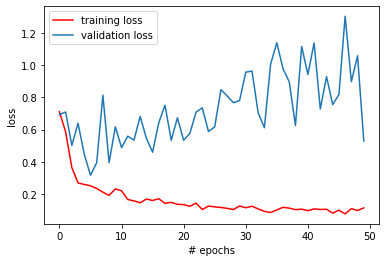

In [13]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

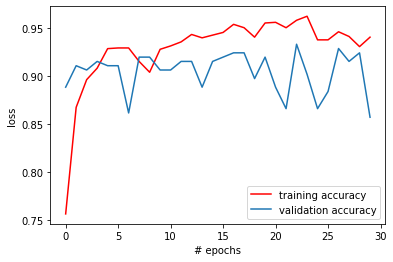

In [9]:
plt.plot(history.history['acc'],'r',label='training accuracy')
plt.plot(history.history['val_acc'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [9]:
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [11]:
labels_dict={0:'without_mask',1:'with_mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(150,150))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        #print(result)
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()